# 估计计数
## 1、火车头问题
佛雷德里克莫斯泰勒的《五十个概率难题的解法》中有如下表述：</br>
铁路上以1到N命名火车头。有一天你看到一个标号60的火车头，请估计铁路上有多少火车头？</br>
想清楚这个问题怎么转化为贝叶斯估计问题：</br>
**假设：**铁路上火车头数为x， 求的是p（x|看到标号60的火车头）——后验概率</br>
在假设的情况下，假设的概率——先验P（x）</br>
在假设的情况下看到标号60火车头的概率——似然P（看到标号60火车头|x）</br>
标准化常量P（60）</br>
先验概率P（x）：假设x是1到1000等概率的任何值</br>
似然P（60|x）：等概率，应为1/x</br>
P（60）= 1</br>

[None, Text(0, 0.5, 'PMF'), Text(0.5, 1.0, 'posterior distribution')]

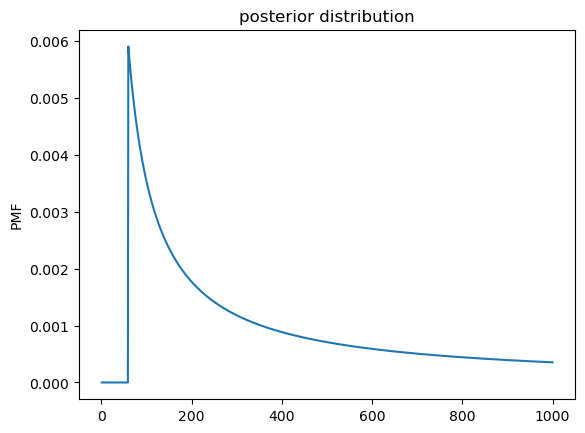

In [2]:
import numpy as np
from empiricaldist import Pmf
import matplotlib.pyplot as plt

hypos = np.arange(1, 1001)
prior = Pmf(1, hypos)

def update_train(pmf, data):
    hypos = pmf.qs
    likelihood = 1 / hypos
    impossible = (data > hypos)
    likelihood[impossible] = 0
    pmf *= likelihood
    pmf.normalize()
    
data = 60
posterior = prior.copy()
update_train(posterior, data)
posterior.plot()
ax = plt.gca()
ax.set(label = 'Number of trains', ylabel = 'PMF', title = 'posterior distribution')

概率最大的值是60，但一般而言恰好看到最终的火车头标号概率并不高，而且已经看到最高60了，这个概率问题也不存在了。还有一种方法时计算**后验概率的平均值分布**：给定可能的值$q_i$，相应的概率为$p_i$,那么分布的平均是$$mean = \sum_ip_iq_i$$

In [23]:
np.sum(posterior.ps * posterior.qs)
# posterior.mean()

333.41989326370776

## 2、先验的敏感性
为了解决火车头问题，我们假设先验概率是1-1000的均匀随机分布，但是上界1000和均匀分布这两个假设并没有特别的理由。在上一章我们遇到了先验湮没，后验概率对先验不敏感，那么这次的后验概率是否对先验敏感？</br>
假设上界分别为500， 1000， 2000， 3000

In [24]:
import pandas as pd

df = pd.DataFrame(columns = ['Posterior mean'])
df.index.name = 'Upper bound'

for high in [500, 1000, 2000, 3000]:
    hypos = np.arange(1, high+1)
    pmf = Pmf(1, hypos)
    update_train(pmf, data = 60)
    df.loc[high] = pmf.mean()
    
df


,Posterior mean
Upper bound,
500,207.079228
1000,333.419893
2000,552.179017
3000,750.150589


可以看得出后验概率对先验是敏感的，这种情概况有两种方法继续进行分析：**获取更多的数据、更多的背景信息**</br>
### （1）获取更多的数据（大数据）
假设除了列车60，我们也看到30和90。可以看到随着数据的增加，后验概率趋向收敛于178

In [5]:
import pandas as pd

df = pd.DataFrame(columns = ['Posterior mean'])
df.index.name = 'Upper bound'

dataset = [30, 60, 90]

for high in [500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 20000, 30000, 40000]:
    hypos = np.arange(1, high+1)
    pmf = Pmf(1, hypos)
    for data in dataset:
        update_train(pmf, data)
    df.loc[high] = pmf.mean()
    
df


,Posterior mean
Upper bound,
500,151.849588
1000,164.305586
2000,171.338181
3000,173.818938
4000,175.086611
5000,175.856181
6000,176.373019
7000,176.744063
8000,177.023379


### （2）更多的背景信息
如果没有更多数据，可以收集更多的背景信息来提高先验。比如，我们假设上限是1000，但是大型和小型的火车有同等上限不合理，大型公司可能有1000台火车头，小型公司仅有1台。小公司多，大公司少，公司的数量与公司规模成反比$$PMF(x)\propto{（\frac{1}{x}）}^\alpha$$其中$\alpha$接近与1

,Posterior mean
Upper bound,
500,130.708470
1000,133.275231
2000,133.997463


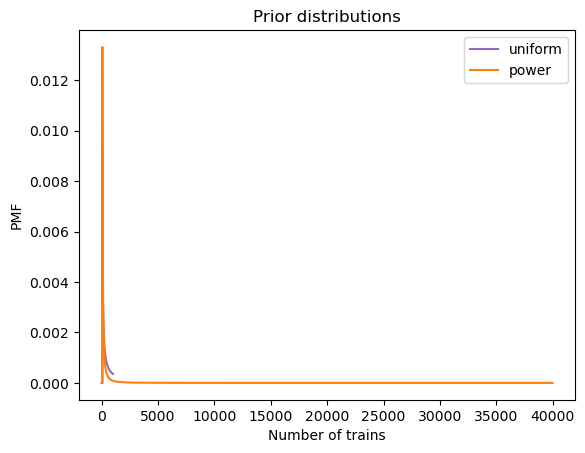

In [6]:
alpha = 0.8
ps = hypos ** (-alpha)
power = Pmf(ps, hypos, name = 'power law')
power.normalize()

hypos = np.arange(1, 1001)
uniform = Pmf(1, hypos, name='uniform')
uniform.normalize()

dataset = [60]
update_train(uniform, dataset)
update_train(power, dataset)

uniform.plot(label = 'uniform', color='C4')
power.plot(label = 'power', color='C1')

ax = plt.gca()
ax.legend()
ax.set(xlabel='Number of trains',
         ylabel='PMF',
         title='Prior distributions')


df = pd.DataFrame(columns=['Posterior mean'])
df.index.name = 'Upper bound'

alpha = 1.0
dataset = [30, 60, 90]

for high in [500, 1000, 2000]:
    hypos = np.arange(1, high+1)
    ps = hypos**(-alpha)
    power = Pmf(ps, hypos)
    for data in dataset:
        update_train(power, data)
    df.loc[high] = power.mean()
    
df

## 3、置信区间
上面取的最大值和平均值都是点估计，也就是说用单个值来估计参数。</br>
点估计</br>
置信区间：给出两个计算值，使得未知量有90%的可能落入这两个值之间。比如给定一个值，叠加所有小于等于这个值的概率（百分位数）


In [7]:
power.prob_le(100)

0.2937469222495771

In [10]:
def quantile(pmf, prob):
    """Compute a quantile with the given prob"""
    total = 0
    for q, p in pmf.items():
        total += p
        if total >= prob:
            return q
    return np.nan

quantile(power, 0.5)
power.quantile([0.05, 0.95])

array([ 91., 243.])

0.05对应91个火车头，0.95对应243个火车头：</br>
* 火车头数只有5%的概率小于91</br>
* 火车头数只有5%的概率大于243</br>
* 火车头数在91-243的概率为90%</br>
以上称为90%置信区间

In [11]:
power.credible_interval(0.9)

array([ 91., 243.])